CIFAR-10 Binary Classification: Animals vs Vehicles
===================================================

This notebook implements a binary classification task on the CIFAR-10 dataset, where we classify images as either "Animals" or "Vehicles". We compare three different types of models:

*   K-Nearest Neighbors (KNN)
    
*   Logistic Regression
    
*   Convolutional Neural Networks (CNN)
    

1\. Libraries and Dependencies
------------------------------

First, we import all the necessary libraries:


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score, f1_score
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import urllib.request
import seaborn as sns
import pandas as pd
import numpy as np
import tarfile
import pickle
import joblib
import os
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc
)

2\. Data Loading and Preprocessing
----------------------------------

### 2.1 Unpickle CIFAR-10 Data

In [ ]:

def unpickle(file):
    """
    Helper function to deserialize the CIFAR-10 pickle files.

    Args:
        file: Path to the CIFAR-10 batch file

    Returns:
        Dictionary containing the data
    """

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

### 2.2 Load and Split Data

In [ ]:
def load_data(data_dir, validation_size=0.2):
    """
    Loads CIFAR-10 dataset from directory and splits it into training, validation, and test sets.
    Args:
        data_dir: Directory path containing CIFAR-10 batch files
        validation_size: Fraction of training data to be used for validation
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test
    """
    X_train = []
    y_train = []

    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        y_train.extend(batch_data[b'labels'])

    X_train = np.vstack(X_train).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_train = np.array(y_train)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=validation_size, random_state=42, stratify=y_train
    )

    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_data = unpickle(test_batch_file)
    X_test = test_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_data[b'labels'])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def plot_class_distribution(y, class_names, title="Class Distribution", save_path=None):
    plt.figure(figsize=(10, 4))
    sns.countplot(x=y)
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()


def plot_pca(X, y_binary, title="PCA Visualization (Binary Classes)", save_path=None):
    X_flat = X.reshape(X.shape[0], -1)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_flat)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[y_binary == 0, 0], X_pca[y_binary == 0, 1], c='blue', label='Vehicle', alpha=0.5, s=10)
    plt.scatter(X_pca[y_binary == 1, 0], X_pca[y_binary == 1, 1], c='green', label='Animal', alpha=0.5, s=10)
    plt.legend()
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()
    return X_pca


def plot_roc_curve(y_true, y_scores, title="ROC Curve", save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()


def plot_training_curves(history, save_path=None):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()


def show_sample_images(X, y, class_names, samples=10, save_path=None):
    plt.figure(figsize=(15, 2))
    indices = np.random.choice(len(X), samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, samples, i + 1)
        plt.imshow(X[idx])
        plt.title(class_names[y[idx]], fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()


def plot_pixel_distribution(X, title="Pixel Value Distribution", save_path=None):
    plt.figure(figsize=(6, 4))
    plt.hist(X.flatten(), bins=50, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()


### 2.3 Convert to Binary Classification

We convert the original 10-class CIFAR-10 labels into a binary classification problem:

*   Class 0: Vehicles (airplane, automobile, ship, truck)
    
*   Class 1: Animals (bird, cat, deer, dog, frog, horse)

In [ ]:
def to_binary_labels(labels):
    """
    Convert CIFAR-10 labels to binary classification (Animals vs Vehicles)

    Args:
        labels: Original CIFAR-10 labels (0-9)

    Returns:
        Binary labels (0 for vehicles, 1 for animals)
    """
    vehicle_classes = [0, 1, 8, 9]  # airplane, automobile, ship, truck
    animal_classes = [2, 3, 4, 5, 6, 7]  # bird, cat, deer, dog, frog, horse

    binary_labels = np.zeros_like(labels)
    for i, label in enumerate(labels):
        if label in vehicle_classes:
            binary_labels[i] = 0  # Vehicle
        elif label in animal_classes:
            binary_labels[i] = 1  # Animal

    return binary_labels

## 2.4 Data Preprocessing
#### This function handles different preprocessing steps for each model type:

#### For KNN and Logistic Regression: Flattens images, standardizes values, and optionally applies PCA
#### For CNN: Normalizes pixel values without flattening

In [ ]:
def preprocess_data(X_train, X_val, X_test, model_type, use_pca=False, n_components=100):
    """
    Preprocess CIFAR-10 image data for model training.
    Args:
        X_train, X_val, X_test: Image datasets
        model_type: 'knn', 'logistic', or 'cnn'
        use_pca: Apply PCA if True (only for knn/logistic)
        n_components: Number of PCA components to retain
    Returns:
        Preprocessed X_train, X_val, X_test
    """
    if model_type in ['knn', 'logistic']:
        # Flatten
        X_train_flat = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255.0
        X_val_flat = X_val.reshape(X_val.shape[0], -1).astype('float32') / 255.0
        X_test_flat = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255.0

        # Standardize
        scaler = StandardScaler()
        X_train_flat = scaler.fit_transform(X_train_flat)
        X_val_flat = scaler.transform(X_val_flat)
        X_test_flat = scaler.transform(X_test_flat)
        joblib.dump(scaler, "saved_models/scaler.pkl")

        # PCA (if required)
        if use_pca:
            pca = PCA(n_components=n_components)
            X_train_flat = pca.fit_transform(X_train_flat)
            X_val_flat = pca.transform(X_val_flat)
            X_test_flat = pca.transform(X_test_flat)
            joblib.dump(pca, "saved_models/pca.pkl")

        return X_train_flat, X_val_flat, X_test_flat

    elif model_type == 'cnn':
        # Normalize only
        X_train_cnn = X_train.astype('float32') / 255.0
        X_val_cnn = X_val.astype('float32') / 255.0
        X_test_cnn = X_test.astype('float32') / 255.0

        return X_train_cnn, X_val_cnn, X_test_cnn

    else:
        raise ValueError("Invalid model_type. Choose from: 'knn', 'logistic', 'cnn'")


In [ ]:
def balance_binary_dataset(X, y):
    X_vehicle = X[y == 0]
    X_animal = X[y == 1]


    X_vehicle_upsampled, y_vehicle_upsampled = resample(
        X_vehicle,
        np.zeros(len(X_vehicle)),
        replace=True,
        n_samples=len(X_animal),
        random_state=42
    )

    X_balanced = np.vstack((X_animal, X_vehicle_upsampled))
    y_balanced = np.hstack((np.ones(len(X_animal)), y_vehicle_upsampled))

    return X_balanced, y_balanced

3\. Model Training Functions
----------------------------



### 3.1 KNN Model Training

In [ ]:
def train_knn_models(X_train, y_train, X_val, y_val):
    """
    Train multiple KNN models with different hyperparameters and return results.

    Parameters:
        X_train: PCA-transformed training features
        y_train: Binary labels for training set
        X_val: PCA-transformed validation features
        y_val: Binary labels for validation set

    Returns:
        Tuple:
            - List of model info dictionaries (sorted by validation accuracy)
            - Best performing KNN model
            - Dictionary of validation probabilities for plotting
    """
    knn_configs = [
        {'n_neighbors': 3, 'weights': 'uniform'},
        {'n_neighbors': 5, 'weights': 'uniform'},
        {'n_neighbors': 7, 'weights': 'uniform'},
        {'n_neighbors': 3, 'weights': 'distance'},
        {'n_neighbors': 5, 'weights': 'distance'},
        {'n_neighbors': 7, 'weights': 'distance'},
    ]

    trained_models = []
    val_probs_dict = {}

    for config in knn_configs:
        k = config['n_neighbors']
        weights = config['weights']
        model_name = f'KNN (k={k}, weights={weights})'
        print(f"\nTraining {model_name}...")

        model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric='euclidean')
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_val_prob = model.predict_proba(X_val)[:, 1]
        report = classification_report(y_val, y_val_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        print(f"Validation Accuracy: {val_acc:.4f}")
        print("Classification Report:")
        print(report)

        trained_models.append({
            'name': model_name,
            'model': model,
            'params': config,
            'val_accuracy': val_acc
        })

        val_probs_dict[model_name] = {
            'y_val_prob':y_val_prob,
            'classification_report': report
          }

    trained_models.sort(key=lambda x: x['val_accuracy'], reverse=True)
    best_model_dict = trained_models[0]  # Full dictionary, not just the model object

    return trained_models, best_model_dict


### 3.2 Logistic Regression Model Training

In [ ]:


def train_logistic_models(X_train, y_train, X_val, y_val_binary):
    """
    Train multiple Logistic Regression models with different hyperparameters,
    handle class imbalance, and evaluate each on validation set.

    Returns:
        models: List of model info dicts sorted by validation accuracy.
        best_model: Model with highest validation accuracy.
        log_reg_results: Dict with evaluation reports for each config.
    """

    log_configs = [
        {'C': 0.1, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'},
        {'C': 1.0, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'},
        {'C': 10.0, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'},
        {'C': 0.1, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced'},
        {'C': 10.0, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced'},
        {'C': 0.1, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced'},
        {'C': 10.0, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced'},
    ]

    models = []
    log_reg_results = {}

    for config in log_configs:
        model_name = f"LogReg_C={config['C']}_solver={config['solver']}_penalty={config['penalty']}"
        print(f"\n Training {model_name}...")

        model = LogisticRegression(max_iter=5000, random_state=42, **config)
        model.fit(X_train, y_train)

        val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val_binary, val_pred)
        f1 = f1_score(y_val_binary, val_pred, average='binary')
        report = classification_report(y_val_binary, val_pred)

        # Store results
        log_reg_results[model_name] = {
            'model': model,
            'val_accuracy': val_acc,
            'f1_score': f1,
            'classification_report': report
        }

        models.append({
            'model': model,
            'params': config,
            'val_accuracy': val_acc,
            'f1_score': f1,
            'name': model_name
        })

        print(f" Validation Accuracy: {val_acc:.4f} | F1 Score: {f1:.4f}")
        print(" Classification Report:\n", report)

    # Sort by validation accuracy
    models.sort(key=lambda x: x['val_accuracy'], reverse=True)

    return models, models[0], log_reg_results



### 3.3 CNN Models

In [ ]:

def create_simple_cnn_model(name="Simple CNN"):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model._name = name
    return model

def create_deeper_cnn_model(name="Deeper CNN"):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model._name = name
    return model

def create_advanced_cnn_model(name="Advanced CNN"):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model._name = name
    return model


def train_cnn_models(X_train, y_train, X_val, y_val, epochs=10, batch_size=64, class_weight=None):
    """
    Trains multiple CNN models and returns them sorted by validation accuracy.

    Returns:
        trained_models: List of dicts with keys ['model', 'history', 'val_acc', 'params']
        best_model: Dict corresponding to the model with the highest validation accuracy
    """
    # Define models to train
    cnn_models = [
    create_simple_cnn_model(),
    create_deeper_cnn_model(),
    create_advanced_cnn_model()
    ]


    trained_models = []

    # Train each model
    for model in cnn_models:
        print(f"\nTraining {model._name} ...")

        model.compile(
            optimizer=Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            class_weight=class_weight,
            verbose=2,
        )

        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        print(f"{model._name} Validation Accuracy: {val_acc:.4f}")
        print("-" * 40)

        trained_models.append({
            'model': model,
            'history': history,
            'val_accuracy': val_acc,
            'params': {'name': model._name}
        })

    # Sort by validation accuracy (descending)
    trained_models.sort(key=lambda x: x['val_accuracy'], reverse=True)
    best_model = trained_models[0]

    return trained_models, best_model



### 4. Model Evaluation

In [ ]:
def evaluate_models(model_entry, X_val, y_val):
    """
    Evaluates a model (either raw or a dictionary with details).
    Returns full metrics: accuracy, classification report, confusion matrix, ROC/PR curves.
    """
    if isinstance(model_entry, dict):
        model = model_entry['model']
        name = model_entry.get('name', model.__class__.__name__)
        history = model_entry.get('history')
        val_probs = model_entry.get('val_probs')
    else:
        model = model_entry
        name = model.__class__.__name__
        history = None
        val_probs = None

    print(f"\nEvaluating {name}")
    print('-' * 40)

    # Plot training history if CNN
    if history:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(acc))

        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Train Accuracy')
        plt.plot(epochs_range, val_acc, label='Val Accuracy')
        plt.title(f'{name} - Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Train Loss')
        plt.plot(epochs_range, val_loss, label='Val Loss')
        plt.title(f'{name} - Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Predict probabilities
    try:
        y_prob = val_probs if val_probs is not None else model.predict_proba(X_val)[:, 1]
    except:
        # For CNN or models with predict() only
        y_raw = model.predict(X_val)
        y_prob = y_raw.ravel() if y_raw.ndim > 1 else y_raw

    # Threshold
    y_pred = (y_prob > 0.5).astype(int)

    # Evaluation metrics
    cm = confusion_matrix(y_val, y_pred)
    cr = classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1'])
    acc = accuracy_score(y_val, y_pred)

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    print("Classification Report:")
    print(cr)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return {
        'name': name,
        'accuracy': acc,
        'classification_report': cr,
        'confusion_matrix': cm,
        'roc_curve': (fpr, tpr),
        'pr_curve': (precision, recall),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

### 5\. Main Execution Function


1. Loading CIFAR-10 data...

2. Preparing binary labels...

3. Visualizing class imbalance...


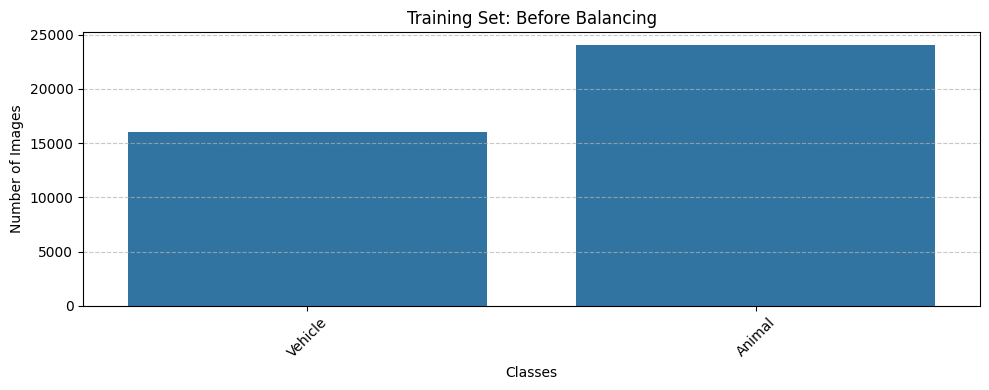

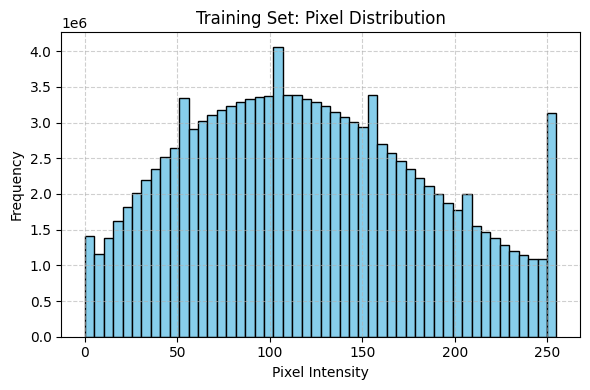

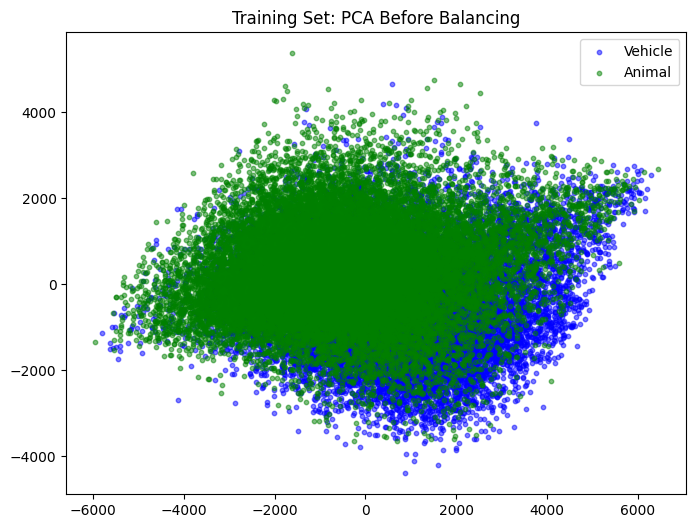


4. Balancing dataset...


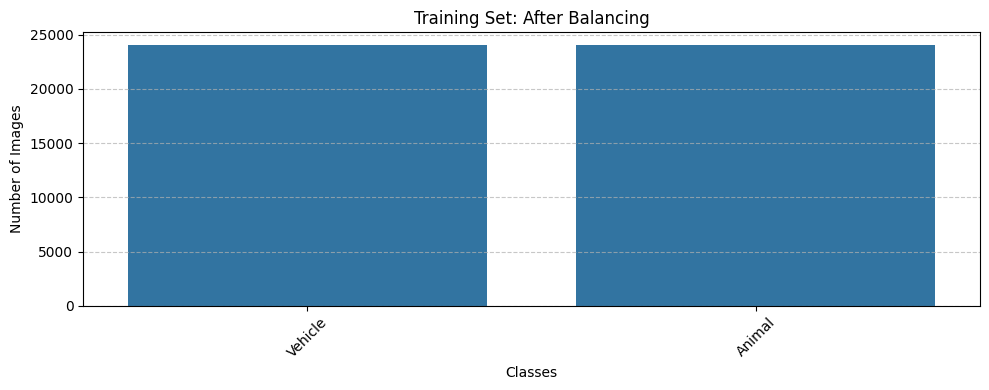

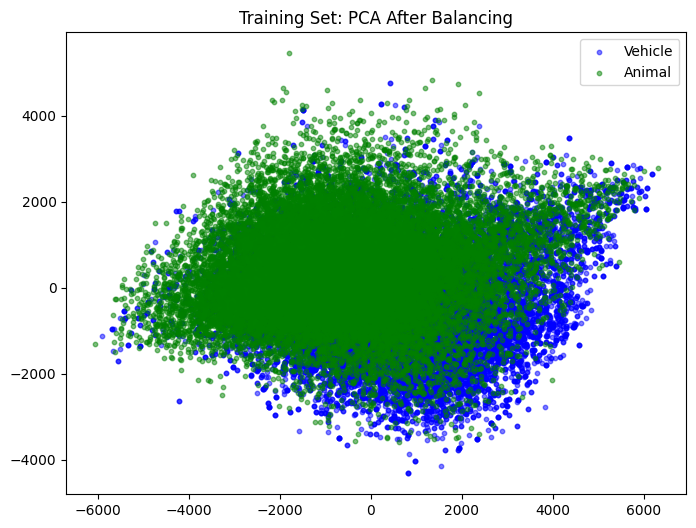


 Preprocessing and visualization complete.

5. Preprocessing for KNN and Logistic Regression...


Loaded saved KNN model.
Loaded saved Logistic Regression model.
Loaded saved CNN model.

6. Evaluating models...

Evaluating KNeighborsClassifier
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      0.73      0.76      4000
     Class 1       0.83      0.88      0.85      6000

    accuracy                           0.82     10000
   macro avg       0.81      0.80      0.81     10000
weighted avg       0.82      0.82      0.82     10000



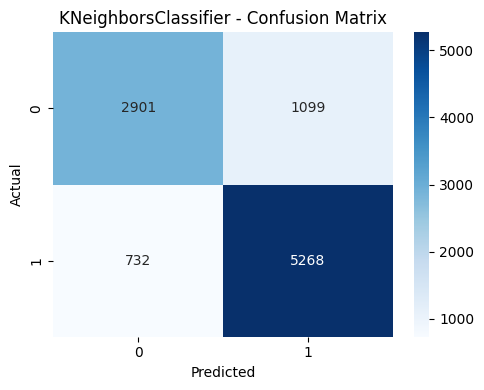


Evaluating LogReg_C=1.0_solver=liblinear_penalty=l1
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.80      0.77      4000
     Class 1       0.86      0.82      0.84      6000

    accuracy                           0.81     10000
   macro avg       0.80      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



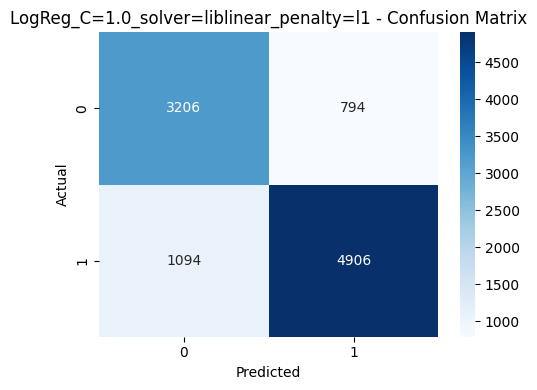


Evaluating Sequential
----------------------------------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.96      0.94      4000
     Class 1       0.97      0.95      0.96      6000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



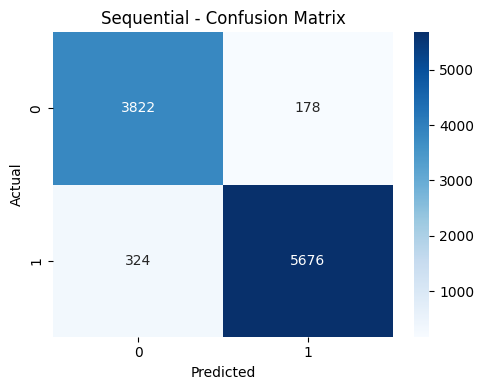


7. Saving evaluation data and test sets...

All models and metrics saved to 'saved_models/'

8. Model Comparison:
  KNN: 0.8169
  Logistic Regression: 0.8112
  CNN: 0.9498

Best model: CNN with accuracy 0.9498


In [ ]:
KNN, LOG, CNN = 0, 0, 0

def main():
    print("\n1. Loading CIFAR-10 data...")
    data_dir = "/content/sample_data/"  # Change as needed
    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_dir)

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # ------------------- Preprocessing -------------------
    print("\n2. Preparing binary labels...")
    y_train_binary = to_binary_labels(y_train)
    y_val_binary = to_binary_labels(y_val)
    y_test_binary = to_binary_labels(y_test)

    os.makedirs("saved_models", exist_ok=True)
    os.makedirs("plots", exist_ok=True)

    # ------------------- Visualization Before Balancing -------------------
    print("\n3. Visualizing class imbalance...")
    plot_class_distribution(y_train_binary, ["Vehicle", "Animal"], "Training Set: Before Balancing", save_path="plots/class_dist_before.png")
    plot_pixel_distribution(X_train, "Training Set: Pixel Distribution", save_path="plots/pixel_distribution.png")
    plot_pca(X_train, y_train_binary, "Training Set: PCA Before Balancing", save_path="plots/pca_before_balancing.png")

    # ------------------- Balancing -------------------
    print("\n4. Balancing dataset...")
    X_train_bal, y_train_bal = balance_binary_dataset(X_train, y_train_binary)
    plot_class_distribution(y_train_bal, ["Vehicle", "Animal"], "Training Set: After Balancing", save_path="plots/class_dist_after.png")
    plot_pca(X_train_bal, y_train_bal, "Training Set: PCA After Balancing", save_path="plots/pca_after_balancing.png")

    print("\n Preprocessing and visualization complete.")

    # ------------------- Preprocessing for Models -------------------
    print("\n5. Preprocessing for KNN and Logistic Regression...")
    X_train_knn, X_val_knn, X_test_knn = preprocess_data(X_train_bal, X_val, X_test, 'knn', use_pca=True, n_components=100)
    X_train_log, X_val_log, X_test_log = preprocess_data(X_train_bal, X_val, X_test, 'logistic', use_pca=True, n_components=100)
    X_train_cnn, X_val_cnn, X_test_cnn = preprocess_data(X_train, X_val, X_test, 'cnn')

    # ------------------- Train KNN -------------------
    knn_path = "saved_models/best_knn_model.joblib"
    if os.path.exists(knn_path):
        best_knn_model = joblib.load(knn_path)
        print("Loaded saved KNN model.")
    else:
        knn_models, best_knn = train_knn_models(X_train_knn, y_train_bal, X_val_knn, y_val_binary)
        best_knn_model = best_knn
        joblib.dump(best_knn_model['model'], knn_path)
        knn_probs = best_knn_model['model'].predict_proba(X_test_knn)[:, 1]
        plot_roc_curve(y_test_binary, knn_probs, "KNN ROC Curve", save_path="plots/roc_knn.png")
        print("Trained and saved new KNN model.")

    # ------------------- Train Logistic Regression -------------------
    log_path = "saved_models/best_log_model.joblib"
    if os.path.exists(log_path):
        best_log_model = joblib.load(log_path)
        print("Loaded saved Logistic Regression model.")
    else:
        log_models, best_log_model, log_results = train_logistic_models(X_train_log, y_train_bal, X_val_log, y_val_binary)
        log_probs = best_log_model['model'].predict_proba(X_test_log)[:, 1]
        LOG = log_models
        joblib.dump(best_log_model, log_path)
        plot_roc_curve(y_test_binary, log_probs, "Logistic Regression ROC Curve", save_path="plots/roc_logistic.png")
        print("Trained and saved new Logistic Regression model.")

    # ------------------- Train CNN -------------------
    cnn_path = "saved_models/best_cnn_model.h5"
    if os.path.exists(cnn_path):
        best_cnn_model = load_model(cnn_path)
        print("Loaded saved CNN model.")
    else:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_bal), y=y_train_bal)
        class_weight_dict = {i: w for i, w in enumerate(class_weights)}
        cnn_models, best_cnn = train_cnn_models(X_train_cnn, y_train_binary, X_val_cnn, y_val_binary, class_weight=class_weight_dict)
        best_cnn_model = best_cnn['model']
        cnn_probs = best_cnn_model.predict(X_test_cnn).ravel()
        CNN = cnn_models
        best_cnn_model.save(cnn_path)
        plot_roc_curve(y_test_binary, cnn_probs, "CNN ROC Curve", save_path="plots/roc_cnn.png")
        plot_training_curves(best_cnn['history'], save_path="plots/cnn_training_curves.png")
        print("Trained and saved new CNN model.")

    # ------------------- Evaluation -------------------
    print("\n6. Evaluating models...")
    knn_metrics = evaluate_models(best_knn_model, X_test_knn, y_test_binary)
    log_metrics = evaluate_models(best_log_model, X_test_log, y_test_binary)
    cnn_metrics = evaluate_models(best_cnn_model, X_test_cnn, y_test_binary)

    # ------------------- Save All -------------------
    print("\n7. Saving evaluation data and test sets...")
    joblib.dump(y_test_binary, "saved_models/y_test.pkl")
    joblib.dump(X_test, "saved_models/X_test_raw.pkl")
    joblib.dump(X_test_knn, "saved_models/X_test_knn.pkl")
    joblib.dump(X_test_log, "saved_models/X_test_log.pkl")
    joblib.dump(X_test_cnn, "saved_models/X_test_cnn.pkl")
    joblib.dump(knn_metrics, "saved_models/knn_metrics.pkl")
    joblib.dump(log_metrics, "saved_models/log_metrics.pkl")
    joblib.dump(cnn_metrics, "saved_models/cnn_metrics.pkl")

    print("\nAll models and metrics saved to 'saved_models/'")

    # ------------------- Print Comparison -------------------
    print("\n8. Model Comparison:")
    comparison = {
        "KNN": knn_metrics["accuracy"],
        "Logistic Regression": log_metrics["accuracy"],
        "CNN": cnn_metrics["accuracy"]
    }
    for model, acc in comparison.items():
        print(f"  {model}: {acc:.4f}")
    best_model = max(comparison, key=comparison.get)
    print(f"\nBest model: {best_model} with accuracy {comparison[best_model]:.4f}")

if __name__ == "__main__":
    main()
